In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools
from tqdm import tqdm
import tqdm.contrib.itertools as tqdm_it

# image sources: https://www.easyhdr.com/examples/

In [14]:
def show(img):
    i = img.astype('uint8')*255 if img.dtype == 'bool' else img
    # print(i.dtype, i.ndim)
    plt.figure(figsize=(10, 10))
    if img.ndim == 3:
        # color
        plt.imshow(img[..., ::-1], interpolation='none')
    else:
        plt.imshow(img, cmap='gray', interpolation='none')
        # plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
    plt.show()

## Read Image

In [15]:
folder = 'cannon'

In [16]:
file_names = os.listdir(folder)
imgs = [(cv2.imread(folder + "/" + f), int(f.split(".")[0])) for f in file_names]
imgs, evs = zip(*imgs)
imgs = np.array(imgs)
# ev = 0 for 1 sec
dt = [2**(-e) for e in evs]
lndt = np.log(dt)
gimgs = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in imgs]
print(f"Loading {len(imgs)} images from folder \"{folder}\", ev:")
print(dt)

Loading 3 images from folder "cannon", ev:
[4, 1, 0.25]


# Alignment

## MTB (TODO)

In [17]:
def mtb(img, threshold = 20):
    med = np.median(img)
    # bimg = np.zeros_like(img, dtype=bool)
    bimg = img >= (med)
    eximg = np.abs(img.astype(int)-med) < threshold
    # low   | low_thre  | high_thre | high
    # F     | F         | T         | T
    # F     | T         | T         | F
    return bimg, eximg

In [18]:
threshold = 20
bimgs, eximgs = zip(*[mtb(i, threshold) for i in gimgs])

# Recovering Response Curve

In [19]:
def SolveResponseCurve(imgs, P, N, z_mid):
    print(f"Z_mid = {z_mid}, P = {P}, N = {N}")

    # pixs[P][N]
    fimgs = [f.flatten() for f in imgs]
    idx = np.random.choice(fimgs[0].shape[0], N, replace=False)
    pixs = np.array([f[idx] for f in fimgs])
    shape = (N*P+255, 256+N)

    # =====================================
    # Ax = b
    # mat A
    A = np.zeros(shape, dtype=float)
    for i in tqdm(range(0, N)):
        # left_up block
        i0 = i*P
        for p in range(P):
            A[i0+p, pixs[p, i]] = 1
        # right_up block
        A[i0:i0+P, 256+i] = -1
    # Z_mid constraint
    A[N*P, z_mid] = 1
    # left_bot block
    i0 = N*P+1-1
    A[i0:i0+254, :254] += np.eye(254)
    A[i0:i0+254, :255] += np.eye(255, k=1)[:254]*(-2)
    A[i0:i0+254, :256] += np.eye(256, k=2)[:254]
    # print(A[i0:i0+254, :256].shape)

    # vec b
    b = np.zeros(shape[0], dtype=float)
   
    b[:N*P] = np.tile(lndt, N)

    # Solve lsq
    x = np.array(np.linalg.lstsq(A, b, rcond=None)[0])
    # =====================================
    g = x[:256]
    e = np.exp(x[256:])
    return g, e


In [20]:
z_mid = (0+255)//2
# N(P-1) > 255
# takes 2x
P = len(bimgs)
N = int((255 / (P-1)) * 2)
print(f"Z_mid = {z_mid}, P = {P}, N = {N}")
shape = (N*P+255, 256+N)

Z_mid = 127, P = 3, N = 255


In [21]:
# [ch, P, h, w]
rgb_imgs = imgs.transpose([3, 0, 1, 2])
rgb_g = [SolveResponseCurve(img, P, N, z_mid)[0] for img in rgb_imgs]

100%|██████████| 255/255 [00:00<00:00, 137438.64it/s]Z_mid = 127, P = 3, N = 255

100%|██████████| 255/255 [00:00<00:00, 102633.87it/s]Z_mid = 127, P = 3, N = 255

100%|██████████| 255/255 [00:00<00:00, 135901.84it/s]Z_mid = 127, P = 3, N = 255



In [24]:
w = lambda z: z-0 if z <= z_mid else 255-z
w = np.vectorize(w)(np.arange(256))
# reverse energy function
inv_f = lambda g, imgs: np.exp(np.sum([w[imgs[p]]*(g[imgs[p]]-lndt[p]) for p in range(P)], axis=0) / np.sum([w[imgs[p]] for p in range(P)]))


In [28]:
imgs = np.array(imgs)
# [ch, p, w, h]
normalize = lambda i: (i-np.min(i))/(np.max(i)-np.min(i))
# after_imgs = [inv_f(g, imgs) for g, imgs in zip(rgb_g, rgb_imgs)]
after = np.array([inv_f(g, imgs) for g, imgs in zip(rgb_g, rgb_imgs)])
# after_norm = (after - after.min(axis=1))
# print(after.min(axis=0).shape)
after_norm = np.array([normalize(img)*255 for img in after]).astype('uint8')
after_norm = after_norm.transpose([1, 2, 0])

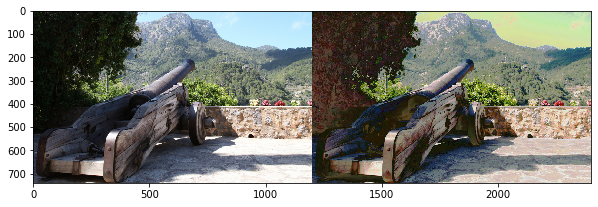

In [29]:
show(np.concatenate([imgs[1], after_norm], axis=1))

# Save as EXR file

In [30]:
import OpenEXR as exr
import array

In [31]:
print(*after.shape[::-1][:2])
f = exr.OutputFile("out.exr", exr.Header(*after.shape[::-1][:2]))
exr_img = [array.array('f', normalize(i).flatten()).tostring() for i in after]
f.writePixels({
    'R':exr_img[0],
    'G':exr_img[1],
    'B':exr_img[2],
})
f.close()

1200 740
<ipython-input-31-6d4ae1a45799>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  exr_img = [array.array('f', normalize(i).flatten()).tostring() for i in after]
